Louding the data

In [2]:
!wget https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip

--2022-12-21 18:47:39--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36517004 (35M) [application/zip]
Saving to: ‘CMP_facade_DB_base.zip’

CMP_facade_DB_base. 100%[===================>]  34.83M  8.43MB/s    in 4.1s    

2022-12-21 18:47:45 (8.43 MB/s) - ‘CMP_facade_DB_base.zip’ saved [36517004/36517004]



In [3]:
! wget https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip

--2022-12-21 18:47:45--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20309906 (19M) [application/zip]
Saving to: ‘CMP_facade_DB_extended.zip’

CMP_facade_DB_exten 100%[===================>]  19.37M  7.59MB/s    in 2.6s    

2022-12-21 18:47:48 (7.59 MB/s) - ‘CMP_facade_DB_extended.zip’ saved [20309906/20309906]



In [4]:
from zipfile import ZipFile
for path in ["/content/CMP_facade_DB_base.zip","/content/CMP_facade_DB_extended.zip"]:
  with ZipFile(path) as zip:
    zip.extractall()

Importing Libraries

In [5]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.6 MB/s 


In [6]:
from skimage.io import imread ,imshow
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder
import segmentation_models as sm

Segmentation Models: using `keras` framework.


Explore the data

preprocessing

In [7]:
import os
train_jpg = []
train_png = []
for i in next(os.walk("/content/base"))[2]:
  if "jpg" in i:
    train_jpg.append(i)
  elif "png" in i:
        train_png.append(i)


In [8]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [9]:
x_train = np.zeros((len(train_jpg), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype= np.uint8)
y_train = np.zeros((len(train_jpg), IMG_WIDTH, IMG_HEIGHT), dtype= np.uint8)

In [10]:
path = "/content/base"
for i,j in  tqdm( enumerate(train_jpg)):
  img = cv2.imread((path +"/"+j), 1)
  img = cv2.resize(img,dsize=(IMG_WIDTH,IMG_HEIGHT))
  x_train[i] = img

for i,j in tqdm(enumerate(train_png)):
  img = cv2.imread((path +"/"+j),0)
  img = cv2.resize(img,dsize=(IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_NEAREST)
  y_train[i] = img


378it [00:03, 123.49it/s]
378it [00:01, 242.74it/s]


In [24]:
num,w,h = y_train.shape
le = LabelEncoder()
y_mask = le.fit_transform(y_train.reshape((-1,1)))
y_mask= y_mask.reshape(num,w,h,1)

In [25]:
y_mask.shape

(378, 256, 256, 1)

In [18]:
np.unique(y_mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [14]:
import tensorflow as tf


In [42]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)
n_classes = 12


# preprocess input
X_train1 = preprocess_input1(x_train)
#X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Linknet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation="softmax")

# compile keras model with defined optimozer, loss and metrics
model1.compile("adam", "sparse_categorical_crossentropy", metrics="accuracy")

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())


history1=model1.fit(x_train, 
          y_mask,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(x_train, y_mask))


model1.save('res34_backbone_50epochs.hdf5')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_136 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

In [ ]:
np.expand_dims(x_train[0], axis=0).shape

1/1 [==============================] - 1s 983ms/step


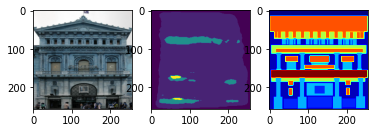

In [43]:
import matplotlib.pyplot as plt

img = cv2.imread("/content/extended/cmp_x0004.jpg", 1)
img = cv2.resize(img,dsize=(IMG_WIDTH,IMG_HEIGHT))

img2 = cv2.imread("/content/extended/cmp_x0004.png", 0)
img2 = cv2.resize(img2,dsize=(IMG_WIDTH,IMG_HEIGHT))

preds = model1.predict(np.expand_dims(img, axis=0))
img_preds = np.argmax(preds,axis = 3)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(np.squeeze(img_preds))
plt.subplot(133)
plt.imshow(img2,cmap="jet")


In [47]:
u = np.logical_and(img_preds,img2)
i = np.logical_or(img_preds,img2)
np()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])

In [ ]:
preds = model1.predict(np.expand_dims(x_train[0], axis=0))

In [ ]:
preds.shape

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
square = 8
ix=1
for _ in range(square):
  for _ in range(square):
    ax = plt.subplot(square,square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(preds[0,:,:,ix-1], cmap="gray")
    ix+=1

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
y_mask.shape

(378, 256, 256, 1)

In [ ]:
train_images = np.expand_dims(x_train, axis = 3)
train_images=normalize(train_images, axis=1)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_cat = to_categorical( y_mask, 12)

In [ ]:
train_cat.shape

(378, 256, 256, 12)

In [ ]:
train_images.shape

(378, 256, 256, 1)

In [ ]:
y_train.shape

(378, 256, 256)

In [ ]:
#Build the model
import tensorflow as tf

inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT, 1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(12, (1, 1), activation='softmax')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
model.summary()
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(train_images, train_cat, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_5 (Lambda)              (None, 256, 256, 1)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_78 (Conv2D)             (None, 256, 256, 16  160         ['lambda_5[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
img = cv2.imread("/content/extended/cmp_x0001.jpg",0)
img_size = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
img_exp = np.expand_dims(img_size, axis=2)
img = normalize(img_exp )
img = np.expand_dims(img, axis=0)


In [ ]:
img.shape

(1, 256, 256, 1)

In [ ]:
train_images[0].shape

(256, 256, 1)

In [ ]:
preds=model.predict(np.expand_dims(train_images[0],axis=0))

1/1 [==============================] - 0s 201ms/step


In [ ]:
train_cat[0].shape

(256, 256, 12)

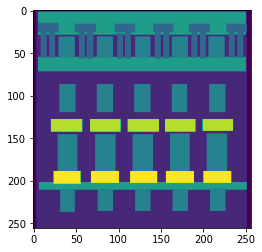

In [ ]:
plt.imshow(np.squeeze(train_cat[100].argmax(2)))

In [ ]:
preds_max = preds.argmax(axis=3)[0,:,:]

In [ ]:
preds.shape

(1, 256, 256, 12)

In [ ]:
(preds[0,0,0])

array([0.1762356 , 0.62093043, 0.02426243, 0.009802  , 0.01304688,
       0.0117656 , 0.00863018, 0.01747739, 0.06204223, 0.00253174,
       0.01702381, 0.03625176], dtype=float32)

In [ ]:
preds_max.shape

(1, 256, 256)

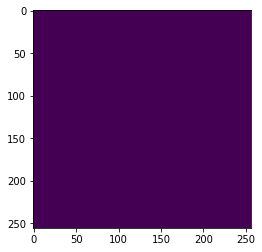

In [ ]:
plt.imshow(np.squeeze(preds_max))